Temporarily deprecated, notebook testing runs migrated to google cloud environment for extra compute support

In [8]:
pip install tensorboardX==2.6

                                              0.0/114.5 kB ? eta -:--:--
     -------------------------------------- 114.5/114.5 kB 6.5 MB/s eta 0:00:00
                                              0.0/904.2 kB ? eta -:--:--
     -------------------------------       768.0/904.2 kB 16.1 MB/s eta 0:00:01
     ------------------------------------- 904.2/904.2 kB 14.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


             date       Open       High        Low      Close    Volume  \
0      2013-05-20  13.450000  13.589500  13.325000  13.381500  44180000   
1      2013-05-21  13.437000  13.538500  13.383000  13.443000  34824000   
2      2013-05-22  13.369500  13.379500  13.040000  13.148000  66640000   
3      2013-05-23  13.024500  13.158500  12.979500  13.090000  40006000   
4      2013-05-24  12.992500  13.096500  12.917000  13.087000  33926000   
...           ...        ...        ...        ...        ...       ...   
101561 2023-05-11  38.900667  38.920334  38.467998  38.821999   5698500   
101562 2023-05-12  38.820000  38.990002  38.349998  38.439999   4798300   
101563 2023-05-15  38.590000  38.730000  38.209999  38.639999   3046100   
101564 2023-05-16  38.430000  38.619999  37.119999  37.130001   5731500   
101565 2023-05-17  37.299999  37.439999  37.060001  37.189999   3258100   

        Dividends  Stock Splits ticker industry  
0           0.000           0.0   AMZN     tech  

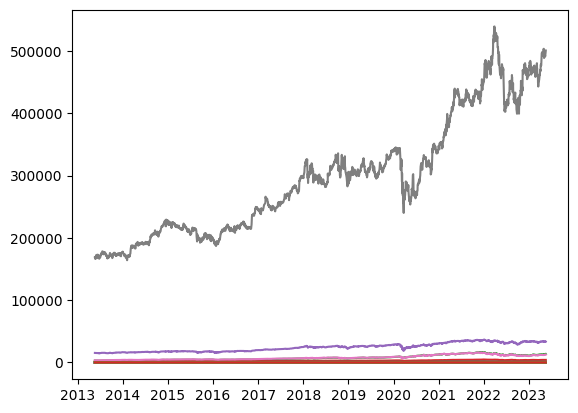

In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

ticker_list_tech = [
    "AMZN", 
    "AAPL", 
    "GOOGL", 
    "MSFT", 
    "NVDA", 
    "META", 
    "TSLA", 
    "AMD", 
    "INTC", 
    "CRM",    
    "SOFI",
    "PYPL",
    "SNOW",
    "ADBE",
    "UBER",
    "ABNB",
    "FUBO",
    "AVGO",
    "ORCL",
    "ASML",
    "CSCO",
    "ACN",
]

ticker_list_energy = [
    "XOM",
    "CVX",
    "SHEL",
    "TTE",
    "COP",
    "BP",
    "EQNR",
    "ENB",
]


ticker_list_market_index = [
    "^NDX", 
    "^GSPC", 
    "^DJI",
    "^RUT",
    "^IXIC",
    
]

ticker_list_financial_services = [
    "BRK-A",
    "BRK-B",
    "V",
    "JPM",
    "MA",
    "BAC",
    "WFC",
    "MS",
    "HSBC",
]
ticker_lists = {
    "tech":ticker_list_tech, 
    "index":ticker_list_market_index, 
    "financial":ticker_list_financial_services,
    "energy":ticker_list_energy,
}

data_frames = []

for key, value in ticker_lists.items():
    for i in value:
        yf_df = yf.Ticker(i)
        data_hist = yf_df.history(period="10y")
        data_hist.index.name = "Date"
        data_hist = data_hist.reset_index().rename(columns={'Date': 'date'})
        data_hist = data_hist.reset_index(drop=True)
        data_hist["date"] = pd.DatetimeIndex(data_hist["date"]).strftime('%Y-%m-%d')
        data_hist = data_hist.reset_index(drop=True)
        data_hist["date"] = pd.to_datetime(data_hist["date"])
        data_hist["ticker"] = i
        data_hist["industry"] = key
        plt.plot(data_hist["date"], data_hist["Close"])
        data_frames.append(data_hist)
   

data_df = pd.concat(data_frames, ignore_index=True)
print(data_df)

In [5]:
import datetime
import json
import logging
import os
import ta
import pickle
import warnings
from typing import Optional, Union
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
import torch
from pytorch_forecasting.data import TimeSeriesDataSet
from pytorch_forecasting.data.encoders import (
    EncoderNormalizer,
    GroupNormalizer,
    MultiNormalizer,
    NaNLabelEncoder,
)
from pytorch_forecasting.metrics import MultiLoss, QuantileLoss
from pytorch_forecasting.models import Baseline, TemporalFusionTransformer
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import (
    optimize_hyperparameters,
)
from pytorch_lightning import seed_everything, Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings("ignore")
seed_everything(42)
logging.getLogger().setLevel(level=logging.INFO)
logger = logging.getLogger("edf")
logger.setLevel(level=logging.INFO)

EDFConfig = {
        "resource": "Closing Price",
        "smoothing_function": None,
        "window_size": 30,
        "training_start_ds": "2013-05-06",
        "training_end_ds": "2023-05-05",
        "forecast_start_ds": "2023-05-08",
        "forecast_end_ds": "2023-06-02",
        # "training_start_ds": "2021-01-01",
        # "training_end_ds": "2022-12-31",
        # "forecast_start_ds": "2023-01-01",
        # "forecast_end_ds": "2023-03-30",
        # "root_path": "./",
        "model_params": {
            "n_jobs": 8,
            "sort_columns": ["industry"],
            "group_columns": ["ticker"],
            "gradient_clip_val": 0.1,
            "dropout": 0.24,
            "batch_size": 64,
            "hidden_size": 24,
            "hidden_continuous_size": 12,
            "attention_head_size": 2,
            "learning_rate": 0.000646,
            "max_encoder_length": 365,
            "min_encoder_length": 30,
            "lstm_layers": 2,
            "root_path": "root_folder",
            "checkpoint_params": {
                "save_top_k": 1,
                "mode": "min",
            },
            "static_categoricals": [],  # namespace, scope
            "trainer_params": {
                "max_epochs": 4,
                "devices": -1,
                "auto_select_gpus": True,
                "limit_train_batches": 1.0,
                "auto_lr_find": False,
                "auto_scale_batch_size": False,
            },
        },
        "data_params": {
            "sort_columns": ["industry"],
            "group_columns": ["ticker"],
        },
        "date_features": {
            "dow": {"transform": True},
            "dom": {"transform": True},
            "doy": {"transform": True},
            "woy": {"transform": True},
            "moy": {"transform": True},
        },
        "target": {
            "value": [
                "value",
            ],  
        },
        "ts_settings": {
            "sort_columns": ["industry"],
            "group_columns": ["ticker"],
            "time_varying_unknown_reals": [
                # "value"
            ],
            "static_reals": [
            ],
            "time_varying_known_categoricals": ["quarter"], #is_weekday
            "scalers": {
                "year": StandardScaler(),
                # add static real values here if they're included
            },
            "lags": {
                "Close": [1, 2, 3, 7, 14, 30, 60, 90],
            },
            "allow_missing_timesteps": True,
            "add_relative_time_idx": True,
            "add_target_scales": True,
            "add_encoder_length": True,
        },
        "tft_settings": {
            "log_interval": -1,
            "log_val_interval": -1,
            "quantile_list": [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98],
            "forecast_quantile": 0.5,
            "reduce_on_plateau_patience": 4,
            "share_single_variable_networks": False,
            "weight_decay": 0.1,
        },
        "hyperparamter_tuning": {
            "model_path": "optuna_tuning",
            "n_trials": 20,
            "max_epochs": 4,
            "gradient_clip_val_range": (0.01, 1.0),
            "hidden_size_range": (8, 128),
            "hidden_continuous_size_range": (8, 128),
            "attention_head_size_range": (1, 4),
            "learning_rate_range": (0.0001, 0.1),
            "dropout_range": (0.0, 0.3),
            "trainer_kwargs": {
                "limit_train_batches": 1.0,
                "default_root_dir": "root_folder",
                "auto_select_gpus": True,
                "enable_progress_bar": True,
                "devices": -1,
                "auto_scale_batch_size": False,
            },
            "reduce_on_plateau_patience": 4,
            "use_learning_rate_finder": True,
        },
    }

config = EDFConfig

Global seed set to 42
Global seed set to 42
Global seed set to 42


In [6]:
class EDF:
    def __init__(self, config: EDFConfig, debug: Optional[bool] = False):
        self.logger = logger
        self.config: EDFConfig = config
        # Training and forecast date references
        self.train_start: pd.Timestamp = pd.to_datetime(config["training_start_ds"])
        self.train_end: pd.Timestamp = pd.to_datetime(config["training_end_ds"])
        self.forecast_start: pd.Timestamp = pd.to_datetime(config["forecast_start_ds"])
        self.forecast_end: pd.Timestamp = pd.to_datetime(config["forecast_end_ds"])
        self.future_forecast: bool = bool(self.forecast_end > pd.to_datetime("today"))
        self.train_dataloader = None
        self.val_dataloader = None
        self.model_path: str = None
        self.model = None
        self.trainer = None
        # Data definitions
        self.data_df: pd.DataFrame = None
        self.training_df: pd.DataFrame = None
        self.holdout_df: pd.DataFrame = None
        self.forecast_df: pd.DataFrame = None
        self.metric_df: pd.DataFrame = None
        # Class behavior setup
        self.debug = debug
        if debug:
            self.logger.setLevel(level=logging.DEBUG)
        # Target data definition
        self.target_set: list = ["Close"]

    # Need to update for yfinance dataset fetch
    def fetcher(self):
        self.fetcher = Fetcher(config=self.config, debug=self.debug)
        return self.fetcher

    def process_data(self, data):
        pass

    # function for transforming date features if configured
    def date_tfs(
        self,
        df: pd.DataFrame,
        date_agg: str,
        tf: str,
        time_varying_known_reals: list,
    ):
        if date_agg == "dow":
            df[date_agg] = df["date"].dt.dayofweek
            divisor = 7
        elif date_agg == "dom":
            df[date_agg] = df["date"].dt.day
            divisor = 30.5
        elif date_agg == "doy":
            df[date_agg] = df["date"].dt.dayofyear
            divisor = 365.25
        elif date_agg == "woy":
            df[date_agg] = df["date"].dt.isocalendar().week
            divisor = 52
        elif date_agg == "moy":
            df[date_agg] = df["date"].dt.month
            divisor = 12
        if tf == True:
            df[date_agg + "_sin"] = np.sin(2 * np.pi * df[date_agg] / divisor)
            df[date_agg + "_cos"] = np.cos(2 * np.pi * df[date_agg] / divisor)
            # Drop the standard version
            df = df.drop(columns=[date_agg])
            # Add column names to tvkr list
            time_varying_known_reals.append(date_agg + "_sin")
            time_varying_known_reals.append(date_agg + "_cos")
        else:
            # If untransformed then just use regular date feature name
            time_varying_known_reals.append(date_agg)
        return df, time_varying_known_reals

    def compute_technical_indicators(self, df):
        # Compute RSI
        df["rsi"] = ta.momentum.RSIIndicator(close=df["Close"]).rsi()

        # Compute MACD
        macd = ta.trend.MACD(close=df["Close"])
        df["macd"] = macd.macd()
        df["macd_signal"] = macd.macd_signal()

        # Compute Bollinger Bands
        bollinger = ta.volatility.BollingerBands(close=df["Close"])
        df["bb_high"] = bollinger.bollinger_hband()
        df["bb_low"] = bollinger.bollinger_lband()

        # Compute Moving Averages
        df["sma_50"] = ta.trend.SMAIndicator(close=df["Close"], window=50).sma_indicator()
        df["sma_200"] = ta.trend.SMAIndicator(close=df["Close"], window=200).sma_indicator()

        return df


    def load_data(self, data_df: pd.DataFrame):
        # Ensure that we have data in our training DataFrame
        assert data_df.shape[0] > 0
        # TODO: most basic data cleaning in another fn
        data_df["date"] = pd.to_datetime(data_df["date"])
        # Split raw data into training and holdout periods
        self.training_df = data_df.loc[
            (data_df["date"] >= self.train_start) & (data_df["date"] <= self.train_end)
        ]
        self.holdout_df = data_df.loc[
            (data_df["date"] >= self.forecast_start)
            & (data_df["date"] <= self.forecast_end)
        ]
        # Ensure that we have data in our training DataFrame
        assert self.training_df.shape[0] > 0
        if self.holdout_df.empty and not self.future_forecast:
            raise ValueError("Not a future forecast and holdout_df contains no data.")
        self.data_df = data_df
        return self.data_df

    def data_setup(
        self, data: Optional[pd.DataFrame] = pd.DataFrame, params: Optional[dict] = {}
    ) -> pd.DataFrame:
        # default_params = get_defaults("data", config=self.config)
        params = {**params}
        # default_ts_settings = get_defaults("ts_settings", config=self.config)
        ts_settings = {**(self.config["ts_settings"])}
        # default_date_features = get_defaults("date_features", config=self.config)
        date_features = {**(self.config["date_features"])}
        # Load in time series settings parameters
        params = {**params, **(self.config["ts_settings"])}
        # Converting to str in order to output all values without error
        output_dict = str(params)
        print(output_dict)
        self.logger.info(
            f"Preparing data for model with parameters {json.dumps(output_dict, indent=2)}"
        )
        # Decide which data to prepare, passed in or training data on the class
        if not data.empty:
            self.logger.info("Preparing data that was passed in to data_setup().")
            data_df = data.copy()
        else:
            assert self.data_df is not None and not self.data_df.empty
            self.logger.info(
                "No data passed in, running data_setup() on the class' data_df."
            )
            data_df = self.data_df.copy()
        # Save a copy of the data before applying any processing
        self.raw_df = data_df.copy()
        # TODO: move to different function
        time_varying_unknown_reals = ts_settings.get("time_varying_unknown_reals")
        target_cols = self.target_set
        data_df["value"] = np.sum([data_df[target] for target in target_cols], axis=0)
        print(data_df.describe())
        print(data_df.dtypes)
        if "task_tier_avg" in time_varying_unknown_reals:
            data_df["task_tier_avg"] = data_df["task_tier_avg"].fillna(4)
        if "engine_proportion" in time_varying_unknown_reals:
            data_df["engine_proportion"] = data_df["engine_proportion"].astype(float)
            data_df["engine_proportion"] = data_df["engine_proportion"].fillna(0.5)
        # Take rolling average of the target
        window_size = params.get("window_size")

        def rolling_avg_fn(x):
            return x.rolling(window=window_size).mean()

        def rolling_max_fn(x):
            return x.rolling(window=window_size).max()

        if params.get("smoothing_function") == "mean":
            smoothing_function = rolling_avg_fn
        elif params.get("smoothing_function") == "max":
            smoothing_function = rolling_max_fn
        if params.get("smoothing_function"):
            data_df["value"] = (
                data_df.sort_values(by=params["sort_columns"])
                .groupby(params["group_columns"])[["value"]]
                .apply(smoothing_function)
            )
        # Add date features
        self.logger.info("Preparing data with configured date features.")
        # incoming value column data contains NAN's, this is a temp fix
        data_df["value"] = data_df["value"].fillna(0.0)
        time_varying_known_reals = ["year"]

        for date_agg, tf in date_features.items():
            transform = tf.get("transform")
            data_df, time_varying_known_reals = self.date_tfs(
                df=data_df,
                date_agg=date_agg,
                tf=transform,
                time_varying_known_reals=time_varying_known_reals,
            )
        self.logger.info("Preparing data with regular date features.")
        # Add categorical date features
        data_df["quarter"] = data_df["date"].dt.quarter
        data_df["quarter"] = data_df["quarter"].astype(str)
        data_df["is_weekday"] = data_df["date"].dt.dayofweek.apply(
            lambda x: "no" if x in (5, 6) else "yes"
        )
        data_df["year"] = data_df["date"].dt.year
        # Limit data to series with more than x days of history and has recent data
        min_series_len = params.get("min_series_len")
        max_date = data_df["date"].max()
        data_df = data_df.groupby("ticker").apply(lambda x: self.compute_technical_indicators(df=x))
        data_df.fillna(method='ffill', inplace=True)
        
        """ Deprecating this function for now, current state is breaking as it returns a series with
        the date column as the index so we see a merge error as there are no similar columns betwenn
        max_data and data_df"""

#         def get_weekly_max(series_data):
#             series_data.set_index("date", inplace=True)
#             weekly_max = series_data.resample("W").max()
#             weekly_max = (
#                 weekly_max.reindex(index=series_data.index)
#                 .fillna(method="bfill")
#                 .fillna(method="ffill")
#             )
#             weekly_max = weekly_max.rename(columns={"value": "weekly_max"})
#             return weekly_max

#         # Calculate weekly max variable
#         max_data = (
#             data_df.sort_values(by=params["sort_columns"])
#             .groupby(params["group_columns"])
#             .apply(lambda x: get_weekly_max(x[["date", "value"]]))
#         )
#         print(max_data)

        # Join everything together, start with ns-scope unique data
        data_df = data_df.set_index(params["group_columns"])
        data_df = data_df.reset_index()
        # Merge data with ns-scope-date unique data
        data_df = data_df.set_index(params["sort_columns"])
        
        # Commented out while weekly max is deprecated
        # data_df = data_df.merge(max_data, left_index=True, right_index=True)
        data_df = data_df.reset_index()
        data_df = data_df.replace([np.inf, -np.inf], np.nan)
        # Fill in null prod and adhoc values with 0 if compute calc
        # if self.config["resource"] == "Warehouse Compute":
        for ind, target in enumerate(self.target_set):
            data_df[target] = data_df[target].fillna(0)
        data_df = data_df.dropna()
        self.logger.info("Finished preparing the data for model.")
        return data_df, time_varying_known_reals

    def model_setup(
        self, data_df: pd.DataFrame, time_varying_known_reals: list, params: dict = {}
    ):
        # default_params = get_defaults("model", config=self.config)
        model_params = {**self.config["model_params"]}
        print(model_params)
        data_df["time_idx"] = data_df.apply(
            lambda x: x["date"].year * 365
            + ((x["date"] - datetime.datetime(x["date"].year, 1, 1)).days + 1),
            axis=1,
        )
        data_df["time_idx"] -= data_df["time_idx"].min()
        # Forecast params
        max_prediction_length = (self.forecast_end - self.forecast_start).days + 1
        # Train and holdout data split
        self.training_df = data_df[lambda x: x["date"] <= self.train_end]
        if not self.future_forecast:
            self.holdout_df = data_df[lambda x: x["date"] >= self.forecast_start]
            # List of training included group combos
            included = self.training_df.apply(
                lambda x: " ".join([x[col] for col in model_params["group_columns"]]),
                axis=1,
            ).values
            data_df["ticker"].loc[
                ~data_df.apply(
                    lambda x: " ".join(
                        [x[col] for col in model_params["group_columns"]]
                    ),
                    axis=1,
                ).isin(included),
            ] = "None"
        # Define dataset
        self.logger.info(f"Defining model to forecast {max_prediction_length} days.")
        # default_ts_settings = get_defaults("ts_settings", config=self.config)
        ts_settings = {**self.config["ts_settings"]}
        print(ts_settings)
        # default_tft_settings = get_defaults("tft_settings", config=self.config)
        tft_settings = {**self.config["tft_settings"]}
        # Pytorch is finnicky with lists vs single values being passed in
        # This handles those intricacies, leaving single values when needed
        if len(self.target_set) > 1:
            target_values = self.target_set
            target_normalizer = MultiNormalizer(
                normalizers=[
                    GroupNormalizer(
                        groups=model_params["group_columns"],
                        transformation="softplus",
                    )
                    for x in self.target_set
                ]
            )
            loss = MultiLoss(
                [
                    QuantileLoss(quantiles=(tft_settings.get("quantile_list")))
                    for x in self.target_set
                ]
            )
            output_size = [
                len(tft_settings.get("quantile_list")) for x in self.target_set
            ]
        else:
            target_values = self.target_set[0]
            target_normalizer = GroupNormalizer(
                groups=model_params["group_columns"],
                transformation="softplus",
            )  #scale_by_group argument to be true? (defaults to false)
            loss = QuantileLoss(quantiles=(tft_settings.get("quantile_list")))
            output_size = len((tft_settings.get("quantile_list")))
        time_varying_unknown_reals = ts_settings.get("time_varying_unknown_reals")
        categorical_encoders = {}
        for stat_cat in set(model_params.get("static_categoricals")):
            categorical_encoders[stat_cat] = NaNLabelEncoder(add_nan=True).fit(
                # This should bring in all categories
                data_df[stat_cat]
            )
        print(categorical_encoders)
        self.training = TimeSeriesDataSet(
            self.training_df,
            time_idx="time_idx",
            target=target_values,
            group_ids=model_params.get("group_columns"),
            static_categoricals=model_params.get("static_categoricals"),
            categorical_encoders=categorical_encoders,
            min_encoder_length=model_params.get("min_encoder_length"),
            max_encoder_length=model_params.get("max_encoder_length"),
            max_prediction_length=max_prediction_length,
            target_normalizer=target_normalizer,
            static_reals=[],
            time_varying_known_categoricals=ts_settings.get(
                "time_varying_known_categoricals"
            ),
            time_varying_known_reals=time_varying_known_reals,
            time_varying_unknown_reals=(self.target_set + time_varying_unknown_reals),
            scalers=ts_settings.get("scalers"),
            lags=ts_settings.get("lags"),  # issue with future forecast
            # lags can only go as far back as max_encoder_length for ff ?
            allow_missing_timesteps=ts_settings.get("allow_missing_timesteps"),
            add_relative_time_idx=ts_settings.get("add_relative_time_idx"),
            add_target_scales=ts_settings.get("add_target_scales"),
            add_encoder_length=ts_settings.get("add_encoder_length"),
        )
        # create training dataset
        
        self.train_dataloader = self.training.to_dataloader(
            train=True,
            batch_size=model_params.get("batch_size"),
            num_workers=model_params.get("n_jobs"),
            persistent_workers=True,
            )
        if not self.future_forecast:
            self.logger.info(
                "Creating a validation dataset to check against predictions."
            )
            self.validation = TimeSeriesDataSet.from_dataset(
                self.training, data_df, stop_randomization=True, predict=True
            )
            self.val_dataloader = self.validation.to_dataloader(
                train=False,
                batch_size=model_params.get("batch_size"),
                num_workers=model_params.get("n_jobs"),
                persistent_workers=True,
            )
        else:
            self.logger.info(
                "Creating a validation dataset using last 90 days of training."
            )
        self.model = TemporalFusionTransformer.from_dataset(
            self.training,
            learning_rate=model_params.get("learning_rate"),
            log_interval=-tft_settings.get("log_interval"),
            log_val_interval=tft_settings.get("log_val_interval"),
            lstm_layers=model_params.get("lstm_layers"),
            hidden_size=model_params.get("hidden_size"),
            hidden_continuous_size=model_params.get(
                "hidden_continuous_size"
            ),  # set to <= hidden_size
            output_size=output_size,  # 7 quantiles by default
            loss=loss,
            attention_head_size=model_params.get("attention_head_size"),
            dropout=model_params.get("dropout"),
            reduce_on_plateau_patience=tft_settings.get("reduce_on_plateau_patience"),
            share_single_variable_networks=tft_settings.get(
                "share_single_variable_networks"
            ),
            weight_decay=tft_settings.get("weight_decay"),
        )
        self.logger.info(
            f"Number of parameters in network: {self.model.size()/1e3:.1f}k"
        )
        self.logger.info(self.model.hparams)

    def train_model(self):
        # default_params = get_defaults("model", config=self.config)
        params = {**self.config["model_params"]}
        filename = (
            "{epoch:02d}-{val_loss:.2f}"
            if not self.future_forecast
            else "{epoch:02d}-{train_loss:.2f}"
        )
        monitor = "val_loss" if not self.future_forecast else "train_loss"
        checkpoint_params = params.get("checkpoint_params")
        checkpoint_callback = ModelCheckpoint(
            monitor=monitor,
            filename=filename,
            save_top_k=checkpoint_params.get("save_top_k"),
            mode=checkpoint_params.get("mode"),
            verbose=True,
        )
        # Device declaration is just broken. With only the accelerator arg, cpu support runs well
        # gpus variable instantiation might be necessary for cuda devices but I'm unsure
        # Define trainer
        gpus = (
            torch.cuda.device_count()
            if (torch.cuda.is_available() and torch.cuda.device_count() >= 1)
            else 0
        )
        
        num_cpus = multiprocessing.cpu_count()
        devices = num_cpus if gpus == 0 else [i for i in range(num_cpus)]
        
        trainer_params = params.get("trainer_params")
        self.logger.debug(f"Found and using {gpus} gpu in model training.")
        self.trainer = Trainer(
            max_epochs=trainer_params.get("max_epochs"),
            accelerator="gpu" if gpus else "cpu",
            # devices=devices,
            # auto_select_gpus=trainer_params.get("auto_select_gpus"),
            gradient_clip_val=params.get("gradient_clip_val"),
            limit_train_batches=trainer_params.get("limit_train_batches"),
            # auto_lr_find=trainer_params.get("auto_lr_find"),
            # auto_scale_batch_size=trainer_params.get("auto_scale_batch_size"),
            callbacks=[checkpoint_callback],
            # resume_from_checkpoint=self.model_path or None,
            default_root_dir=params.get("root_path"),
        )
        try:
            if self.model_path and self.model:
                self.logger.info(
                    f"Will continue training model from checkpoint {self.model_path}"
                )
                self.trainer.fit(
                    self.model,
                    ckpt_path=self.model_path,
                    train_dataloaders=self.train_dataloader,
                    val_dataloaders=self.val_dataloader,
                )
            else:
                self.logger.info("Beginning to train new model...")
                self.trainer.fit(
                    self.model,
                    train_dataloaders=self.train_dataloader,
                    val_dataloaders=self.val_dataloader,
                )
        except KeyboardInterrupt:
            self.logger.info("Model training shopped short. Continuing.")
        print(self.train_dataloader)
        print(self.val_dataloader)
        self.logger.info("Model training complete.")

    def load_model(self, version: int, checkpoint: str) -> None:
        # default_params = get_defaults("model", config=self.config)
        params = {**self.config["model_params"], **(self.config)}
        # TODO: need to make sure model is appropriate for the given config
        checkpoint_path = os.path.join(
            params.get("root_path"), "lightning_logs/", f"version_{version}/"
        )
        self.model_path = os.path.join(checkpoint_path, "checkpoints/", checkpoint)
        self.model = TemporalFusionTransformer.load_from_checkpoint(self.model_path)
        self.logger.info(f"Loaded model from {self.model_path}.")
        self.logger.warn(
            "Loading model to continue training will create a new version."
        )

    def compare_to_baseline(self) -> None:
        if not self.val_dataloader or self.future_forecast:
            self.logger.error(
                "No validation dataloader found, unable to check prediction accuracy."
            )
            return None
        if self.trainer:
            self.model_path = self.trainer.checkpoint_callback.best_model_path
            self.logger.info(
                f"Found a Trainer, using best model path {self.model_path}."
            )
        else:
            self.logger.info(f"No trainer found, loading model from {self.model_path}.")
        model = TemporalFusionTransformer.load_from_checkpoint(self.model_path)
        self.logger.debug("Model loaded from checkpoint.")
        predictions, x = model.predict(self.val_dataloader, return_x=True)
        self.logger.debug("Holdout predictions made.")
        # calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
        for ind, target in enumerate(self.target_set):
            actuals = torch.cat([row[1][0][ind] for row in iter(self.val_dataloader)])
            baseline_predictions = Baseline().predict(self.val_dataloader)
            self.logger.info(target)
            self.logger.info(
                f"Model MAE: {(actuals - predictions[ind]).abs().mean()}"
            )  # MAE
            self.logger.info(
                f"Baseline MAE: {(actuals - baseline_predictions[ind]).abs().mean().item()}"
            )

    def predict(self):
        if self.trainer:
            self.model_path = self.trainer.checkpoint_callback.best_model_path
            self.logger.info(
                f"Found a Trainer, using best model path {self.model_path}."
            )
        else:
            self.logger.info(f"No trainer found, loading model from {self.model_path}.")
        model = TemporalFusionTransformer.load_from_checkpoint(self.model_path)
        if not self.future_forecast:
            predictions, x = model.predict(
                self.val_dataloader, mode="raw", return_x=True
            )
            series = self.validation.x_to_index(x)
        else:
            # default_params = get_defaults("model", config=self.config)
            params = {**self.config["model_params"], **(self.config)}
            max_prediction_length = (self.forecast_end - self.forecast_start).days + 1
            max_encoder_length = params.get("max_encoder_length")
            # select last [encoder_length] days from data
            encoder_data = self.training_df[
                lambda x: x.time_idx > x.time_idx.max() - max_encoder_length
            ]
            # select last known data point and create decoder data from it
            last_data = self.training_df[lambda x: x.time_idx == x.time_idx.max()]
            decoder_data = pd.concat(
                [
                    last_data.assign(date=lambda x: x.date + pd.offsets.Day(i))
                    for i in range(1, max_prediction_length + 1)
                ],
                ignore_index=True,
            )
            # Add time index consistent with encoder data
            decoder_data["time_idx"] = decoder_data.apply(
                lambda x: x["date"].year * 365
                + ((x["date"] - datetime.datetime(x["date"].year, 1, 1)).days + 1),
                axis=1,
            )
            decoder_data["time_idx"] += (
                encoder_data["time_idx"].max() + 1 - decoder_data["time_idx"].min()
            )
            date_features = params.get("date_features")
            time_varying_known_reals = ["year"]
            for date_agg, tf in date_features.items():
                transform = tf.get("transform")
                decoder_data, time_varying_known_reals = self.date_tfs(
                    df=decoder_data,
                    date_agg=date_agg,
                    tf=transform,
                    time_varying_known_reals=time_varying_known_reals,
                )
            # Add categorical date features
            decoder_data["quarter"] = decoder_data["date"].dt.quarter
            decoder_data["quarter"] = decoder_data["quarter"].astype(str)
            decoder_data["is_weekday"] = decoder_data["date"].dt.dayofweek.apply(
                lambda x: "no" if x in (5, 6) else "yes"
            )
            decoder_data["year"] = decoder_data["date"].dt.year
            # Clear to-be-predicted data
            ts_settings = params.get("ts_settings")
            time_varying_unknown_reals = ts_settings.get("time_varying_unknown_reals")
            decoder_data[self.target_set] = 0
            for col in time_varying_unknown_reals:
                decoder_data[col] = 0
            # Combine encoder and decoder data
            prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)
            # data_params = get_defaults("data", self.config)
            prediction_data = prediction_data.sort_values(
                by=params.get("sort_columns")
            )
            predictions, x = model.predict(
                prediction_data, mode="raw", return_x=True
            )  # prediction
            series = self.training.x_to_index(x)
        index = pd.date_range(
            start=self.forecast_start, end=self.forecast_end, name="date"
        )
        # default_tft_settings = get_defaults("tft_settings", config=self.config)
        tft_settings = {**self.config["tft_settings"]}
        # default_data_params = get_defaults("data", self.config)
        data_params = {
            **self.config["data_params"],
        }
        all_preds = []
        # format is predictions[forecast_values][scope][day] which gets you to the quantiles
        # below 0 is forecast values, idx is scope, and ind is day
        for idx in range(len(series)):
            preds_df = pd.DataFrame()
            print(preds_df)
            
            for ind, target in enumerate(self.target_set):
                cols = [
                    f"{target}-{quantile}"
                    for quantile in tft_settings.get("quantile_list")
                ]
                # depending on number of targets passed in, the shape of predictions changes
                # if statement below handles those differences
                if len(self.target_set) > 1:
                    predictions_insert = predictions[0][ind][idx].numpy()
                else:
                    predictions_insert = predictions[0][idx].numpy()
                # format with just one target is predictions[forecast_values][scope][day]
                if preds_df.empty:
                    preds_df = pd.DataFrame(
                        predictions_insert, index=index, columns=cols
                    )
                else:
                    target_df = pd.DataFrame(
                        predictions_insert, index=index, columns=cols
                    )
                    preds_df = preds_df.merge(target_df, on="date")
            for col in data_params.get("group_columns"):
                preds_df[col] = series.iloc[idx][col]
            all_preds.append(preds_df)
        self.forecast_df = pd.concat(all_preds).reset_index()
        return self.forecast_df

    def tune_hyperparameters(self):
        if not self.train_dataloader or not self.val_dataloader:
            raise ValueError("Tuning requires a training and validation dataloader")
        logger.info("Tunining hyperparameters")
        hyperparamter_tuning_params = {
            **self.config["hyperparamter_tuning"],
        }
        # create study
        study = optimize_hyperparameters(
            self.train_dataloader,
            self.val_dataloader,
            model_path=hyperparamter_tuning_params.get("model_path"),
            n_trials=hyperparamter_tuning_params.get("n_trials"),
            max_epochs=hyperparamter_tuning_params.get("max_epochs"),
            gradient_clip_val_range=hyperparamter_tuning_params.get(
                "gradient_clip_val_range"
            ),
            hidden_size_range=hyperparamter_tuning_params.get("hidden_size_range"),
            hidden_continuous_size_range=hyperparamter_tuning_params.get(
                "hidden_continuous_size_range"
            ),
            attention_head_size_range=hyperparamter_tuning_params.get(
                "attention_head_size_range"
            ),
            learning_rate_range=hyperparamter_tuning_params.get("learning_rate_range"),
            dropout_range=hyperparamter_tuning_params.get("dropout_range"),
            trainer_kwargs=hyperparamter_tuning_params.get("trainer_kwargs"),
            reduce_on_plateau_patience=hyperparamter_tuning_params.get(
                "reduce_on_plateau_patience"
            ),
            use_learning_rate_finder=hyperparamter_tuning_params.get(
                "use_learning_rate_finder"
            ),
        )
        # save study results - also we can resume tuning at a later point in time
        with open("test_study.pkl", "wb") as fout:
            pickle.dump(study, fout)
        # show best hyperparameters
        print(study.best_trial.params)

    def evaluate_holdout(self):
        # validation metrics are likely going to live in another file
        pass
    def metric_summary(self):
        # validation metrics are likely going to live in another file
        pass

    def plot_holdout(self):
        # leaving this here in case vis support is easier to bake in
        def plot_function():
    
            
            pass

In [8]:
edf = EDF(config=config, debug=False)
edf.load_data(data_df=data_df)
data_df, time_varying_known_reals = edf.data_setup(data=data_df,params={})

{'sort_columns': ['industry'], 'group_columns': ['ticker'], 'time_varying_unknown_reals': [], 'static_reals': ['histogram_mode', 'linearity'], 'time_varying_known_categoricals': ['quarter'], 'scalers': {'year': StandardScaler(), 'histogram_mode': StandardScaler(), 'linearity': StandardScaler()}, 'lags': {'Close': [1, 2, 3, 7, 14, 30]}, 'allow_missing_timesteps': True, 'add_relative_time_idx': True, 'add_target_scales': True, 'add_encoder_length': True}
                Open           High            Low          Close  \
count  101367.000000  101367.000000  101367.000000  101367.000000   
mean     8543.427422    8598.487471    8478.813454    8539.175426   
std     48556.169721   48883.784756   48159.014206   48520.434313   
min         1.050000       1.110000       0.960000       1.040000   
25%        33.888822      34.224567      33.545201      33.877338   
50%        67.402564      68.079154      66.716742      67.416496   
75%       201.228854     203.800003     198.871579     201.3

In [9]:
edf.model_setup(data_df=data_df, time_varying_known_reals=time_varying_known_reals)

{'n_jobs': 8, 'sort_columns': ['industry'], 'group_columns': ['ticker'], 'gradient_clip_val': 0.1, 'dropout': 0.24, 'batch_size': 64, 'hidden_size': 24, 'hidden_continuous_size': 12, 'attention_head_size': 2, 'learning_rate': 0.000646, 'max_encoder_length': 365, 'min_encoder_length': 30, 'lstm_layers': 2, 'root_path': 'root_folder', 'checkpoint_params': {'save_top_k': 1, 'mode': 'min'}, 'static_categoricals': [], 'trainer_params': {'max_epochs': 4, 'devices': -1, 'auto_select_gpus': True, 'limit_train_batches': 1.0, 'auto_lr_find': False, 'auto_scale_batch_size': False}}
{'sort_columns': ['industry'], 'group_columns': ['ticker'], 'time_varying_unknown_reals': [], 'static_reals': ['histogram_mode', 'linearity'], 'time_varying_known_categoricals': ['quarter'], 'scalers': {'year': StandardScaler(), 'histogram_mode': StandardScaler(), 'linearity': StandardScaler()}, 'lags': {'Close': [1, 2, 3, 7, 14, 30]}, 'allow_missing_timesteps': True, 'add_relative_time_idx': True, 'add_target_scales':

In [18]:
edf.train_model()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 12    
3  | prescalers                         | ModuleDict                      | 528   
4  | static_variable_selection          | VariableSelectionNetwork        | 3.4 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 27.1 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 17.4 K
7

Epoch 0: 100%|██████████| 2185/2185 [2:09:41<00:00,  3.56s/it, loss=122, v_num=7, train_loss_step=159.0, train_loss_epoch=324.0]

Epoch 0, global step 2185: 'train_loss' reached 323.83316 (best 323.83316), saving model to 'root_folder\\lightning_logs\\version_7\\checkpoints\\epoch=00-train_loss=323.83.ckpt' as top 1


Epoch 1: 100%|██████████| 2185/2185 [1:59:29<00:00,  3.28s/it, loss=92.4, v_num=7, train_loss_step=29.20, train_loss_epoch=95.30]

Epoch 1, global step 4370: 'train_loss' reached 95.28826 (best 95.28826), saving model to 'root_folder\\lightning_logs\\version_7\\checkpoints\\epoch=01-train_loss=95.29.ckpt' as top 1


Epoch 2: 100%|██████████| 2185/2185 [2:11:08<00:00,  3.60s/it, loss=66.8, v_num=7, train_loss_step=60.20, train_loss_epoch=76.90]  

Epoch 2, global step 6555: 'train_loss' reached 76.86411 (best 76.86411), saving model to 'root_folder\\lightning_logs\\version_7\\checkpoints\\epoch=02-train_loss=76.86.ckpt' as top 1


Epoch 3: 100%|██████████| 2185/2185 [2:32:30<00:00,  4.19s/it, loss=58.4, v_num=7, train_loss_step=140.0, train_loss_epoch=69.80]  

Epoch 3, global step 8740: 'train_loss' reached 69.84103 (best 69.84103), saving model to 'root_folder\\lightning_logs\\version_7\\checkpoints\\epoch=03-train_loss=69.84.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 2185/2185 [2:32:30<00:00,  4.19s/it, loss=58.4, v_num=7, train_loss_step=140.0, train_loss_epoch=69.80]
None


In [10]:
#Below is the model for the 05-01-2023 through 05-06-2023
edf.load_model(version=7, checkpoint="epoch=03-train_loss=69.84.ckpt")
results_df = edf.predict()

Loading model to continue training will create a new version.


Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFr

In [11]:
results_df
hist_df = data_df


The difference between the forecast value and historical 'Close' value is: -2.26


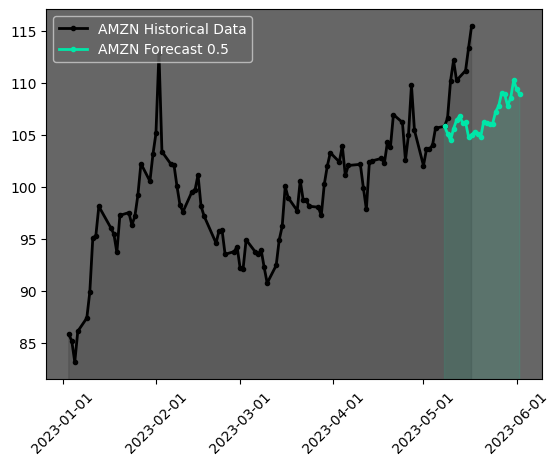

<bound method NDFrame.head of           date  Close-0.02   Close-0.1  Close-0.25   Close-0.5  Close-0.75  \
130 2023-05-08   96.207146  101.618210  104.936226  105.830002  112.817619   
131 2023-05-09   95.806221  100.984154  104.347649  105.140846  112.144714   
132 2023-05-10   95.290962  100.482376  103.815399  104.481308  111.439659   
133 2023-05-11   96.018425  101.497658  104.879021  105.604401  112.618248   
134 2023-05-12   96.333755  102.060898  105.604210  106.424263  113.293747   
135 2023-05-13   96.448433  102.461212  105.938065  106.815704  113.613808   
136 2023-05-14   96.041298  101.685776  105.326309  106.183983  112.732376   
137 2023-05-15   96.184280  101.534897  105.342979  106.224968  112.650780   
138 2023-05-16   95.400810  100.435463  104.086815  104.812119  111.245697   
139 2023-05-17   95.530655  100.799751  104.319748  104.984909  111.397079   
140 2023-05-18   95.588661  101.092896  104.624802  105.316742  111.894966   
141 2023-05-19   95.060371  100.69

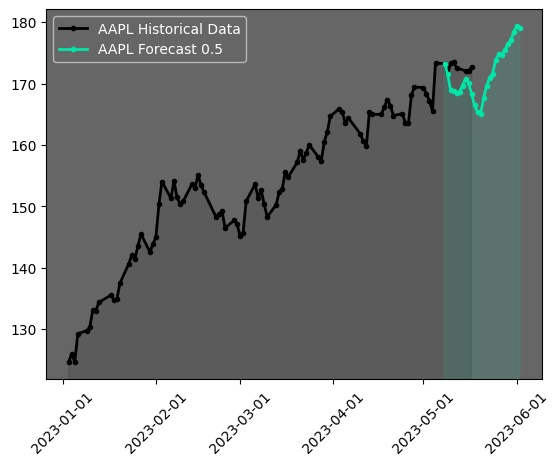

<bound method NDFrame.head of          date  Close-0.02   Close-0.1  Close-0.25   Close-0.5  Close-0.75  \
0  2023-05-08  136.951813  143.822937  153.713791  173.260345  169.180847   
1  2023-05-09  137.371582  143.380661  152.537720  171.604553  167.732849   
2  2023-05-10  135.482758  141.142944  150.463562  169.005386  164.867279   
3  2023-05-11  134.906525  140.463257  150.218292  168.791153  164.644531   
4  2023-05-12  133.686401  139.441254  149.759613  168.468933  163.685242   
5  2023-05-13  132.797028  139.403900  149.804474  168.699677  163.428177   
6  2023-05-14  133.357269  140.096344  150.533371  169.688812  163.579300   
7  2023-05-15  134.834564  141.539520  151.508362  170.788712  164.235947   
8  2023-05-16  135.314575  142.199295  151.043610  170.175613  163.688690   
9  2023-05-17  133.046906  140.692841  149.376434  168.322617  161.648605   
10 2023-05-18  131.008469  138.727310  147.704575  166.442169  160.469208   
11 2023-05-19  128.819489  136.650757  146.499

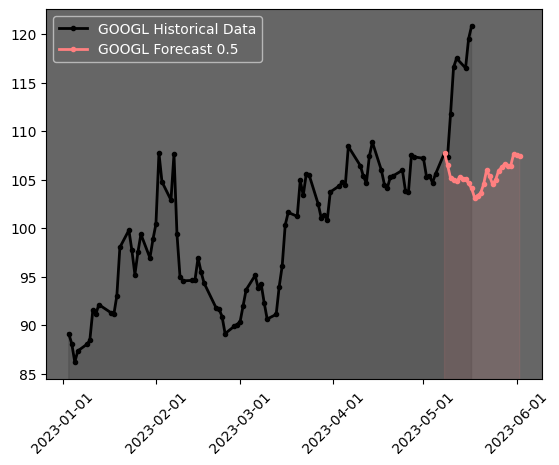

<bound method NDFrame.head of           date  Close-0.02   Close-0.1  Close-0.25   Close-0.5  Close-0.75  \
494 2023-05-08   99.425697  104.417038  108.315392  107.769997  116.757957   
495 2023-05-09   99.034912  103.654831  107.302658  106.503761  115.445374   
496 2023-05-10   98.086197  102.691879  106.183571  105.178009  113.938309   
497 2023-05-11   97.739708  102.629494  105.951363  104.918510  113.618271   
498 2023-05-12   97.259285  102.538330  105.810249  104.837280  113.324722   
499 2023-05-13   97.129822  102.440399  106.105743  105.232811  113.720749   
500 2023-05-14   96.727264  101.639160  105.896606  105.056267  113.369644   
501 2023-05-15   96.669258  101.167984  105.926491  105.083862  113.229324   
502 2023-05-16   96.599503  100.933746  105.560799  104.610771  112.794243   
503 2023-05-17   95.695557  100.193970  105.090988  104.108734  112.268974   
504 2023-05-18   94.876434   99.542351  104.227402  103.153107  111.530228   
505 2023-05-19   94.647530   99.68

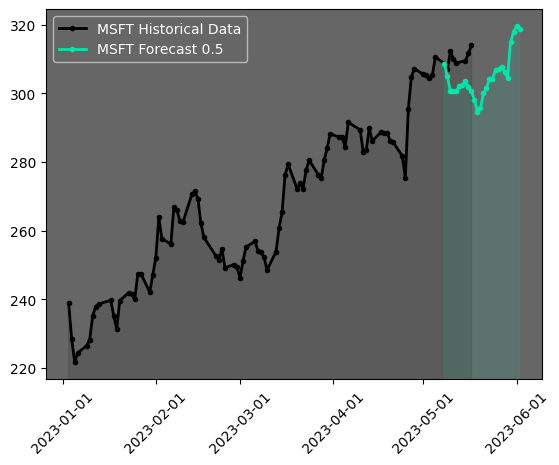

<bound method NDFrame.head of           date  Close-0.02   Close-0.1  Close-0.25   Close-0.5  Close-0.75  \
676 2023-05-08  274.516724  285.310913  297.989868  308.649994  320.732117   
677 2023-05-09  273.924408  283.204163  295.034760  304.947693  317.263031   
678 2023-05-10  270.650970  279.358856  291.398315  300.660095  312.484863   
679 2023-05-11  269.960785  278.781708  291.347076  300.655029  312.436584   
680 2023-05-12  268.405853  277.828125  291.229462  300.852234  311.705688   
681 2023-05-13  267.511780  278.224121  292.001740  302.075592  312.237549   
682 2023-05-14  267.080292  277.875977  292.091858  302.339844  311.319336   
683 2023-05-15  268.553986  279.192230  293.328522  303.658142  311.815613   
684 2023-05-16  268.264862  279.031677  291.777649  301.748810  310.031586   
685 2023-05-17  265.968994  277.995239  290.621094  300.683838  308.515869   
686 2023-05-18  262.788635  275.245209  288.233856  298.156311  307.207886   
687 2023-05-19  258.017212  270.73

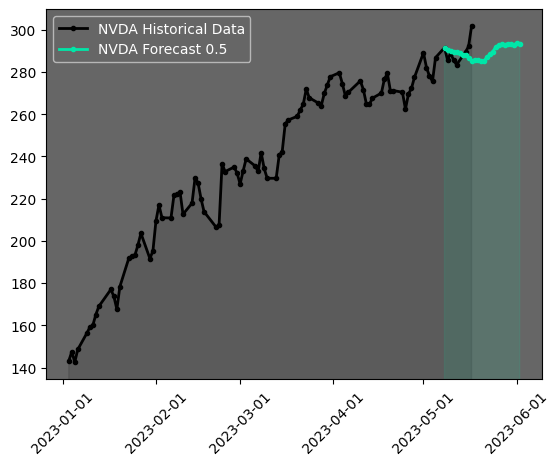

<bound method NDFrame.head of           date  Close-0.02   Close-0.1  Close-0.25   Close-0.5  Close-0.75  \
702 2023-05-08  211.779877  218.255646  230.545715  291.510010  248.923279   
703 2023-05-09  213.177338  218.693878  229.996368  290.553589  248.432373   
704 2023-05-10  212.741272  218.481873  229.661926  289.936890  247.376068   
705 2023-05-11  212.534668  217.885834  229.182098  289.538177  246.976288   
706 2023-05-12  211.347900  216.713470  228.729828  289.423157  245.690247   
707 2023-05-13  209.348083  216.000305  227.846954  288.946625  244.425232   
708 2023-05-14  208.966003  214.831116  226.928558  288.115875  242.430023   
709 2023-05-15  209.931946  215.382202  227.031067  287.890289  242.171295   
710 2023-05-16  210.178650  216.014526  226.228424  286.721893  241.261993   
711 2023-05-17  207.680115  215.244812  224.973053  285.381226  239.609467   
712 2023-05-18  206.858490  215.139496  225.031525  285.760284  240.971283   
713 2023-05-19  204.192474  213.10

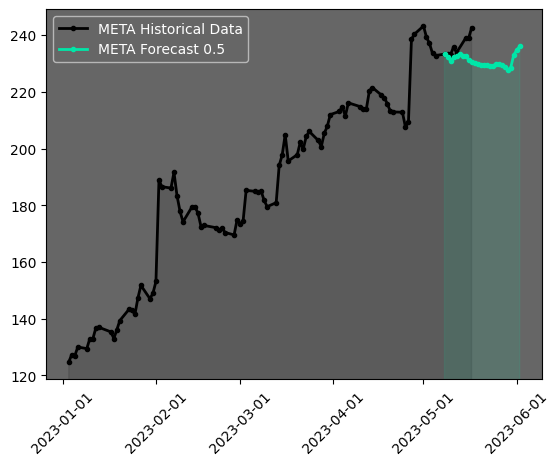

<bound method NDFrame.head of           date  Close-0.02   Close-0.1  Close-0.25   Close-0.5  Close-0.75  \
624 2023-05-08  204.298264  216.155045  223.284332  233.270004  240.812775   
625 2023-05-09  204.222717  215.569122  222.587585  232.329758  239.936844   
626 2023-05-10  203.164825  214.535446  221.445297  230.942551  238.450165   
627 2023-05-11  204.022339  215.643280  222.583954  232.149887  239.652191   
628 2023-05-12  203.673676  215.596619  222.843750  232.588455  239.778229   
629 2023-05-13  203.730362  215.983932  223.283844  233.163849  240.207352   
630 2023-05-14  203.551926  215.132263  222.893692  232.781418  239.383911   
631 2023-05-15  203.916824  214.627167  222.964142  232.758438  239.019257   
632 2023-05-16  203.424820  213.779388  221.820816  231.335388  237.661194   
633 2023-05-17  202.634750  213.087906  221.200180  230.534988  236.775635   
634 2023-05-18  201.742462  212.962158  220.797699  230.175217  236.756592   
635 2023-05-19  200.451263  212.29

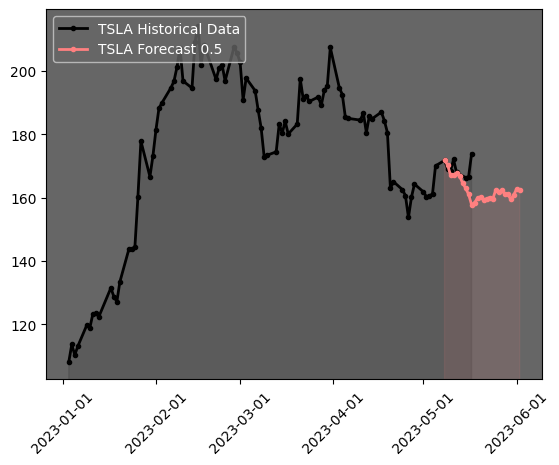

<bound method NDFrame.head of           date  Close-0.02   Close-0.1  Close-0.25   Close-0.5  Close-0.75  \
858 2023-05-08  148.635956  163.374237  174.984085  171.789993  199.210724   
859 2023-05-09  148.641296  161.986481  174.024109  170.384598  198.044189   
860 2023-05-10  146.383942  159.504776  171.329254  167.105896  194.344406   
861 2023-05-11  146.186157  159.763855  171.527206  167.300949  194.495041   
862 2023-05-12  145.418961  159.793060  171.719849  167.747025  194.410904   
863 2023-05-13  143.269073  157.390671  170.784225  166.864975  193.600494   
864 2023-05-14  141.403671  155.359436  168.718048  164.689194  190.630890   
865 2023-05-15  139.930725  152.780807  167.204941  163.030136  188.475800   
866 2023-05-16  139.533997  152.011383  165.670059  161.098816  186.601608   
867 2023-05-17  136.631516  149.295258  162.796265  157.786270  183.175903   
868 2023-05-18  136.777222  150.392242  163.368805  158.451813  184.329895   
869 2023-05-19  136.680679  151.21

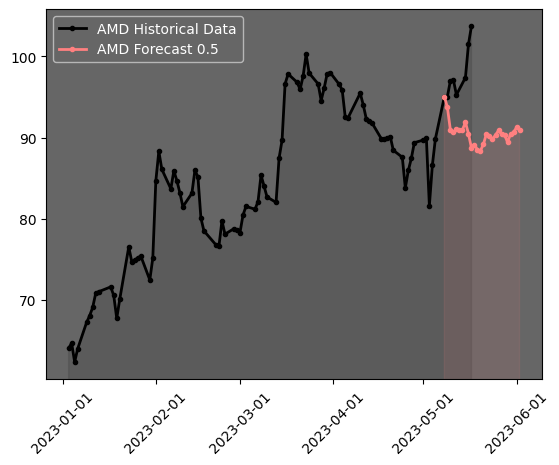

<bound method NDFrame.head of           date  Close-0.02  Close-0.1  Close-0.25  Close-0.5  Close-0.75  \
104 2023-05-08   85.656250  91.091568   96.832924  95.040001  107.633224   
105 2023-05-09   85.638107  90.383339   95.845818  93.707932  106.332977   
106 2023-05-10   83.734322  88.137268   93.505302  90.912529  103.199165   
107 2023-05-11   83.336227  87.806320   93.273109  90.635742  102.889328   
108 2023-05-12   83.063934  87.786179   93.577667  91.091232  103.023819   
109 2023-05-13   82.369499  87.547035   93.405571  90.977715  102.701851   
110 2023-05-14   82.168976  87.315384   93.367783  90.971100  102.256561   
111 2023-05-15   83.027451  88.095688   94.212524  91.869095  102.798431   
112 2023-05-16   82.627350  87.591110   93.106003  90.491348  101.421120   
113 2023-05-17   80.878143  86.038177   91.518852  88.707062   99.544403   
114 2023-05-18   80.664543  86.079605   91.768394  89.102577  100.305389   
115 2023-05-19   79.631538  85.204315   91.096436  88.5013

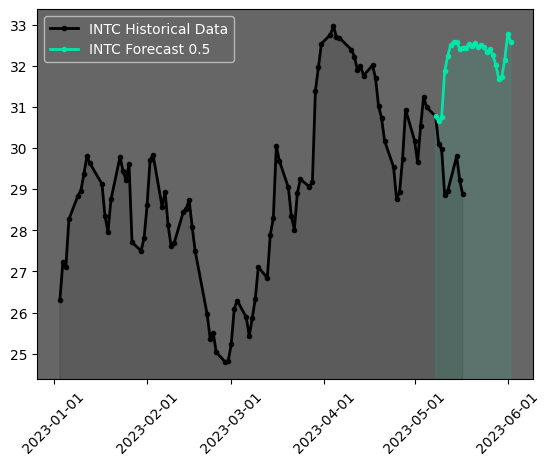

<bound method NDFrame.head of           date  Close-0.02  Close-0.1  Close-0.25  Close-0.5  Close-0.75  \
546 2023-05-08   28.121576  29.384399   30.151255  30.770000   31.606342   
547 2023-05-09   28.052938  29.249615   30.041088  30.645996   31.459702   
548 2023-05-10   28.162930  29.381659   30.163521  30.757767   31.554129   
549 2023-05-11   29.076817  30.491861   31.262041  31.860100   32.657238   
550 2023-05-12   29.323250  30.812733   31.609097  32.229996   32.994896   
551 2023-05-13   29.520401  31.103357   31.868248  32.505768   33.249729   
552 2023-05-14   29.611320  31.130993   31.921593  32.566357   33.249287   
553 2023-05-15   29.663574  31.118788   31.936338  32.582233   33.235847   
554 2023-05-16   29.610945  31.000580   31.785748  32.412735   33.068699   
555 2023-05-17   29.638544  31.072456   31.823977  32.438725   33.093281   
556 2023-05-18   29.591978  31.050571   31.815855  32.435074   33.137295   
557 2023-05-19   29.581774  31.080853   31.889566  32.5281

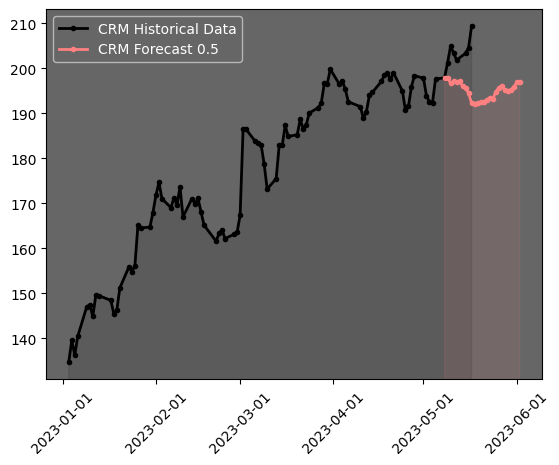

<bound method NDFrame.head of           date  Close-0.02   Close-0.1  Close-0.25   Close-0.5  Close-0.75  \
338 2023-05-08  182.120224  192.497177  198.681656  197.899994  213.772888   
339 2023-05-09  182.926239  192.500885  198.859589  197.887634  213.849030   
340 2023-05-10  182.145432  191.529861  197.936035  196.726379  212.536102   
341 2023-05-11  182.189697  191.777466  198.240601  197.067764  212.871063   
342 2023-05-12  181.354309  191.489777  198.029236  196.995728  212.483994   
343 2023-05-13  180.777496  191.114365  198.010101  197.081604  212.510681   
344 2023-05-14  179.686890  189.548416  196.931396  195.952454  211.010620   
345 2023-05-15  179.461548  188.373383  196.663788  195.607483  210.377594   
346 2023-05-16  179.207092  187.712524  195.799377  194.493347  209.325012   
347 2023-05-17  177.258224  186.125336  193.867996  192.275345  207.042831   
348 2023-05-18  176.806015  186.433472  193.742981  192.173279  207.240952   
349 2023-05-19  176.084869  186.57

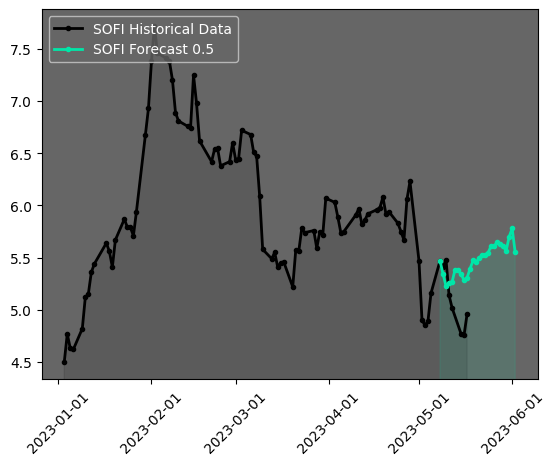

<bound method NDFrame.head of           date  Close-0.02  Close-0.1  Close-0.25  Close-0.5  Close-0.75  \
832 2023-05-08    5.874713   6.414438    6.954457   5.470000    7.662807   
833 2023-05-09    5.779948   6.287394    6.841303   5.344000    7.535523   
834 2023-05-10    5.675451   6.172649    6.729503   5.226566    7.416374   
835 2023-05-11    5.687674   6.203625    6.768213   5.257936    7.462721   
836 2023-05-12    5.660020   6.190369    6.771995   5.265865    7.462031   
837 2023-05-13    5.750306   6.332176    6.899874   5.385583    7.580658   
838 2023-05-14    5.767457   6.314740    6.893275   5.380739    7.550139   
839 2023-05-15    5.756036   6.262487    6.849939   5.340662    7.498133   
840 2023-05-16    5.745251   6.225435    6.795191   5.284138    7.439133   
841 2023-05-17    5.764218   6.272633    6.823611   5.307795    7.462659   
842 2023-05-18    5.815825   6.361537    6.912564   5.395281    7.569291   
843 2023-05-19    5.838937   6.418440    6.984072   5.4730

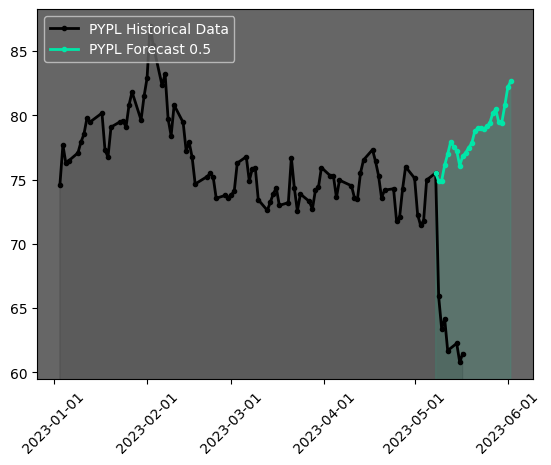

<bound method NDFrame.head of           date  Close-0.02  Close-0.1  Close-0.25  Close-0.5  Close-0.75  \
754 2023-05-08   57.910995  66.156914   70.745491  75.519997   79.616272   
755 2023-05-09   57.577560  65.467194   70.204391  74.882446   78.838531   
756 2023-05-10   57.690517  65.597977   70.297295  74.917465   78.770630   
757 2023-05-11   58.571774  66.684288   71.463188  76.131393   80.091438   
758 2023-05-12   58.894798  67.217117   72.203995  76.989471   80.793884   
759 2023-05-13   59.506401  68.263214   73.089012  77.942657   81.648392   
760 2023-05-14   59.471252  67.678223   72.688629  77.567551   80.915100   
761 2023-05-15   59.487839  67.200287   72.380714  77.246216   80.434662   
762 2023-05-16   59.058105  66.363075   71.341232  76.099655   79.295685   
763 2023-05-17   59.660995  67.386566   72.145416  76.818054   79.997269   
764 2023-05-18   59.554356  67.547195   72.392273  77.100128   80.557770   
765 2023-05-19   59.280560  67.546249   72.669510  77.4940

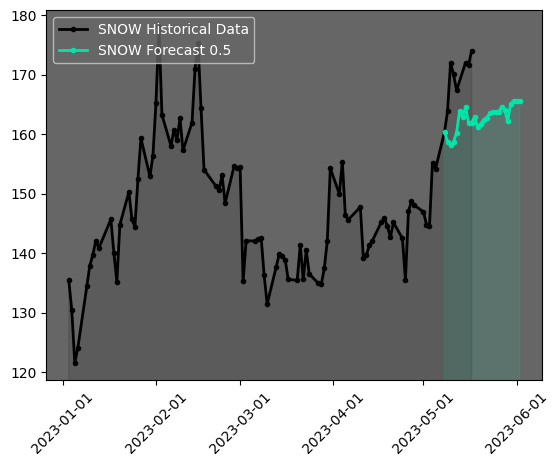

<bound method NDFrame.head of           date  Close-0.02   Close-0.1  Close-0.25   Close-0.5  Close-0.75  \
806 2023-05-08  139.148666  143.978455  151.230591  160.419998  159.983856   
807 2023-05-09  137.925369  142.404877  149.640930  158.742813  158.311340   
808 2023-05-10  137.470703  142.062683  149.192535  158.182602  157.752167   
809 2023-05-11  137.875946  142.741638  149.882263  158.758301  158.503052   
810 2023-05-12  138.921509  144.289429  151.527191  160.280777  159.986435   
811 2023-05-13  142.101868  148.607391  155.559402  163.942841  163.750916   
812 2023-05-14  141.380463  147.205811  154.323242  162.849792  162.306107   
813 2023-05-15  143.276672  149.141678  156.267136  164.618790  164.018082   
814 2023-05-16  141.313553  146.361633  153.371368  161.937164  161.215149   
815 2023-05-17  141.299225  146.615128  153.417908  161.958054  161.224854   
816 2023-05-18  141.918045  147.673813  154.470917  162.975403  162.471344   
817 2023-05-19  139.720993  145.24

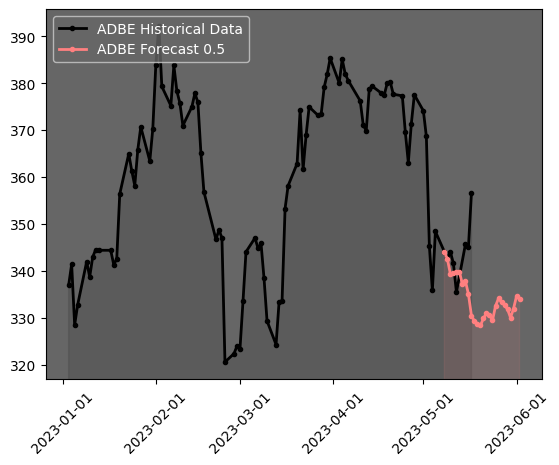

<bound method NDFrame.head of           date  Close-0.02   Close-0.1  Close-0.25   Close-0.5  Close-0.75  \
78  2023-05-08  341.173523  365.858215  381.540222  344.059998  419.002625   
79  2023-05-09  341.463806  364.818359  380.576294  342.490662  417.586609   
80  2023-05-10  339.124512  362.293854  377.993683  339.311676  414.096039   
81  2023-05-11  338.665100  362.503601  378.150818  339.515625  414.309204   
82  2023-05-12  337.066772  361.763367  377.942871  339.659302  413.808228   
83  2023-05-13  336.008240  361.517700  377.906677  339.762817  413.717651   
84  2023-05-14  333.744171  358.000610  375.422455  337.135986  410.224976   
85  2023-05-15  334.879242  357.078247  376.319275  337.801575  410.221741   
86  2023-05-16  334.037109  355.201691  374.117279  335.005737  407.558350   
87  2023-05-17  329.856598  351.570618  370.100342  330.413635  402.860626   
88  2023-05-18  327.726288  351.163757  368.811279  329.247681  402.387390   
89  2023-05-19  325.049622  350.06

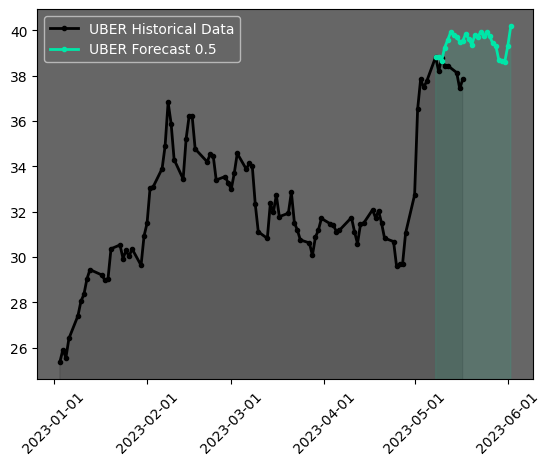

<bound method NDFrame.head of           date  Close-0.02  Close-0.1  Close-0.25  Close-0.5  Close-0.75  \
910 2023-05-08   31.786280  32.577953   33.245232  38.830002   34.439667   
911 2023-05-09   31.866049  32.601063   33.271515  38.849895   34.454521   
912 2023-05-10   31.729776  32.425526   33.090183  38.671528   34.273731   
913 2023-05-11   32.219696  33.007301   33.667763  39.246090   34.869438   
914 2023-05-12   32.449715  33.296982   33.984833  39.579586   35.179527   
915 2023-05-13   32.724297  33.663937   34.322739  39.926044   35.508797   
916 2023-05-14   32.662891  33.501526   34.194824  39.805099   35.334213   
917 2023-05-15   32.634968  33.390926   34.114082  39.723846   35.229465   
918 2023-05-16   32.523121  33.211849   33.908504  39.504330   35.010784   
919 2023-05-17   32.537006  33.283005   33.949192  39.531479   35.036987   
920 2023-05-18   32.754478  33.601013   34.273121  39.855923   35.397446   
921 2023-05-19   32.445999  33.293388   34.020134  39.6246

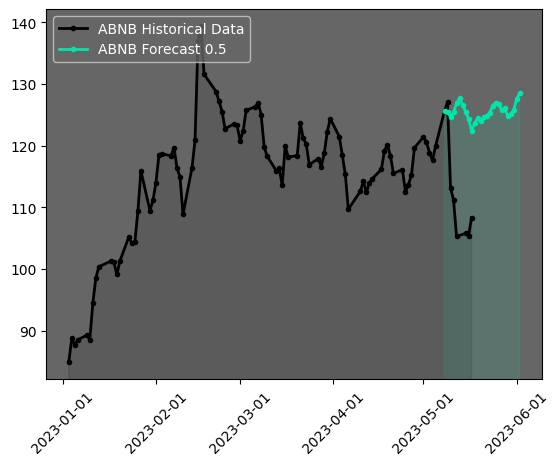

<bound method NDFrame.head of          date  Close-0.02   Close-0.1  Close-0.25   Close-0.5  Close-0.75  \
26 2023-05-08  110.691299  113.910004  116.473503  125.650002  120.073257   
27 2023-05-09  110.549881  113.676140  116.325134  125.417213  119.807953   
28 2023-05-10  109.900345  112.930855  115.601448  124.677238  119.043915   
29 2023-05-11  110.483757  113.727814  116.424179  125.452782  119.891861   
30 2023-05-12  111.545441  115.158432  117.902939  126.903938  121.297836   
31 2023-05-13  112.148674  116.063881  118.726578  127.724937  122.085861   
32 2023-05-14  111.354752  114.871643  117.614349  126.656738  120.884056   
33 2023-05-15  110.529320  113.641548  116.456528  125.548035  119.711174   
34 2023-05-16  109.693756  112.472305  115.217163  124.343437  118.488243   
35 2023-05-17  107.944847  110.428055  113.151688  122.417595  116.516022   
36 2023-05-18  108.865570  111.712715  114.412338  123.601944  117.826683   
37 2023-05-19  109.394943  112.528488  115.296

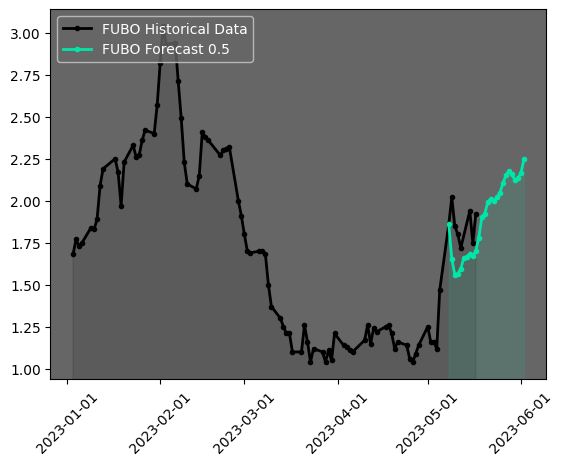

<bound method NDFrame.head of           date  Close-0.02  Close-0.1  Close-0.25  Close-0.5  Close-0.75  \
468 2023-05-08    1.435770   2.118259    3.075211   1.860000    4.296589   
469 2023-05-09    1.325018   1.952043    2.891029   1.654917    4.089983   
470 2023-05-10    1.266302   1.891840    2.811487   1.560157    3.991787   
471 2023-05-11    1.255552   1.895898    2.822333   1.566586    4.018434   
472 2023-05-12    1.235754   1.893488    2.842724   1.595166    4.030867   
473 2023-05-13    1.262339   1.971120    2.908779   1.660886    4.090917   
474 2023-05-14    1.294793   1.959143    2.911997   1.667523    4.053895   
475 2023-05-15    1.338035   1.964946    2.929050   1.684026    4.053188   
476 2023-05-16    1.379497   1.989712    2.924642   1.670277    4.037414   
477 2023-05-17    1.399191   2.052850    2.963371   1.702384    4.070057   
478 2023-05-18    1.420552   2.119795    3.038261   1.780857    4.180436   
479 2023-05-19    1.445066   2.198682    3.147490   1.9008

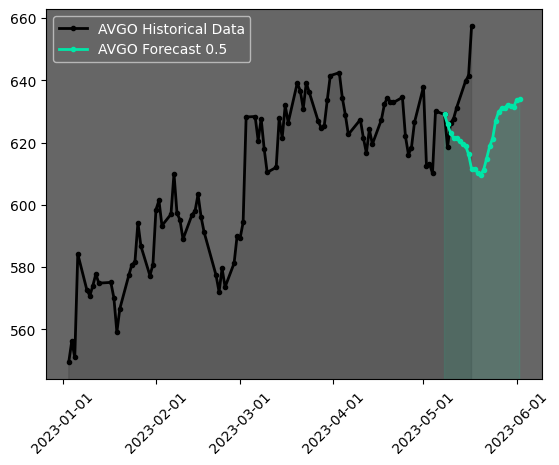

<bound method NDFrame.head of           date  Close-0.02   Close-0.1  Close-0.25   Close-0.5  Close-0.75  \
182 2023-05-08  536.283386  553.267700  582.229675  629.059998  624.239685   
183 2023-05-09  538.674500  553.610596  580.184326  625.940674  622.388306   
184 2023-05-10  536.353271  551.485596  578.141357  623.135193  618.693848   
185 2023-05-11  535.207092  549.608276  576.704834  621.514465  617.110718   
186 2023-05-12  532.280701  546.951294  575.814636  621.343201  614.364563   
187 2023-05-13  528.007263  545.671997  574.163635  620.453979  611.689209   
188 2023-05-14  527.253357  544.115234  572.927429  619.429565  608.208801   
189 2023-05-15  529.067017  545.316895  573.031677  618.976685  607.490295   
190 2023-05-16  529.570374  546.439941  570.935730  616.281616  605.356018   
191 2023-05-17  522.604309  543.163696  566.816406  611.521729  600.092957   
192 2023-05-18  520.510315  542.421021  566.559692  611.667908  602.318970   
193 2023-05-19  514.446716  537.37

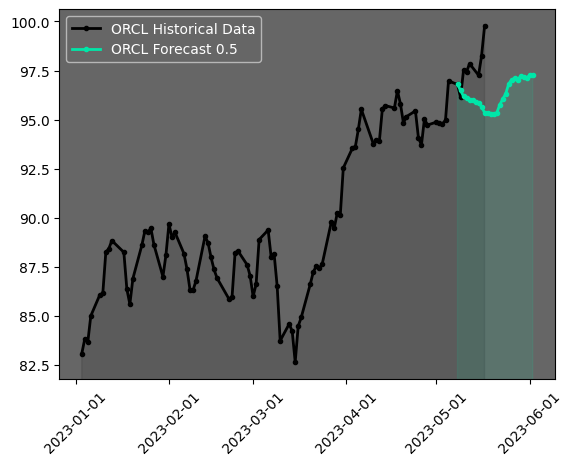

<bound method NDFrame.head of           date  Close-0.02  Close-0.1  Close-0.25  Close-0.5  Close-0.75  \
728 2023-05-08   82.334824  84.094536   86.916595  96.790001   91.150955   
729 2023-05-09   82.520897  83.982956   86.635780  96.483406   90.864227   
730 2023-05-10   82.276367  83.753456   86.414444  96.186020   90.475235   
731 2023-05-11   82.195511  83.596786   86.301605  96.076706   90.351105   
732 2023-05-12   81.839508  83.285065   86.162460  95.979866   90.017181   
733 2023-05-13   81.488998  83.218895   86.052963  96.001945   89.811913   
734 2023-05-14   81.389587  82.996201   85.892776  95.890495   89.431931   
735 2023-05-15   81.571732  83.073105   85.892471  95.862602   89.384537   
736 2023-05-16   81.678459  83.186386   85.689041  95.640541   89.211288   
737 2023-05-17   81.143349  83.023926   85.409729  95.354652   88.838249   
738 2023-05-18   80.864433  82.981094   85.395828  95.317070   89.045639   
739 2023-05-19   80.341995  82.556580   85.309586  95.2976

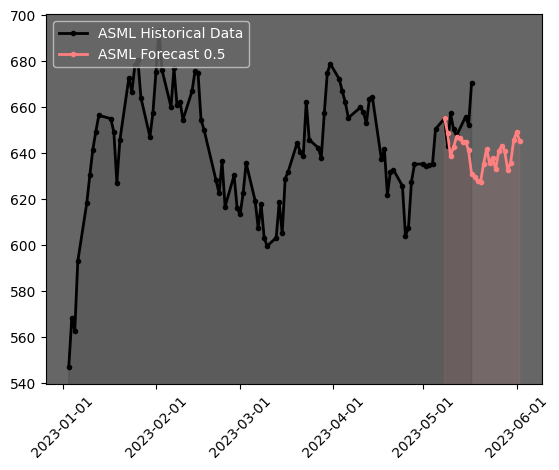

<bound method NDFrame.head of           date  Close-0.02   Close-0.1  Close-0.25   Close-0.5  Close-0.75  \
156 2023-05-08  628.563965  653.672363  682.456543  654.989990  734.506958   
157 2023-05-09  629.068115  650.455933  677.576904  648.710327  728.773010   
158 2023-05-10  621.643738  641.607422  669.097717  638.631348  717.399536   
159 2023-05-11  623.533691  643.319458  672.379028  642.473267  720.848755   
160 2023-05-12  623.253540  643.892334  675.513062  646.952087  722.459106   
161 2023-05-13  618.661499  642.830200  674.269409  646.387817  720.034607   
162 2023-05-14  615.991699  640.395752  672.492004  644.672607  715.518311   
163 2023-05-15  617.228333  641.272583  672.995483  644.912964  714.216919   
164 2023-05-16  617.068604  641.479492  669.935425  641.085754  710.702332   
165 2023-05-17  605.808960  632.888916  660.838623  630.819946  700.010620   
166 2023-05-18  601.983643  630.348389  659.032104  629.329712  701.054810   
167 2023-05-19  595.561035  624.90

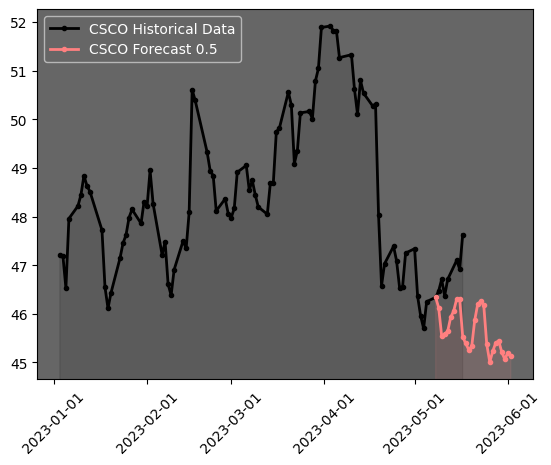

<bound method NDFrame.head of           date  Close-0.02  Close-0.1  Close-0.25  Close-0.5  Close-0.75  \
364 2023-05-08   48.686081  50.563595   51.896675  46.340000   54.896523   
365 2023-05-09   48.710747  50.376549   51.744537  46.127972   54.719658   
366 2023-05-10   48.284485  49.876907   51.247475  45.546238   54.066101   
367 2023-05-11   48.253304  49.886253   51.285339  45.581364   54.098221   
368 2023-05-12   48.142033  49.885117   51.315491  45.641678   54.062111   
369 2023-05-13   48.177372  49.997986   51.557156  45.929142   54.332550   
370 2023-05-14   48.181026  49.953064   51.660461  46.060070   54.359734   
371 2023-05-15   48.383808  50.109200   51.891335  46.306355   54.511864   
372 2023-05-16   48.529045  50.245869   51.912926  46.302799   54.513412   
373 2023-05-17   47.855648  49.591228   51.228645  45.528248   53.707333   
374 2023-05-18   47.677090  49.453232   51.097015  45.391190   53.668896   
375 2023-05-19   47.448868  49.304131   50.944683  45.2624

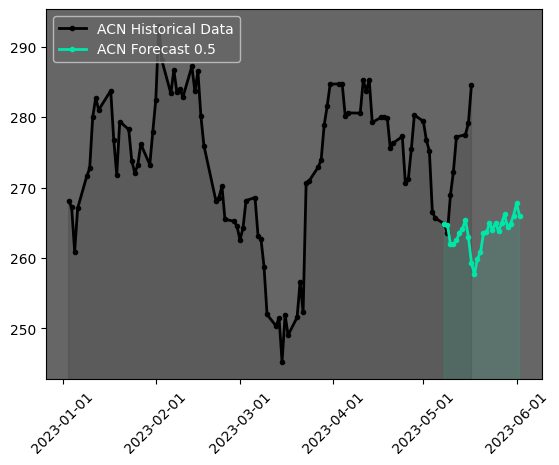

<bound method NDFrame.head of          date  Close-0.02   Close-0.1  Close-0.25   Close-0.5  Close-0.75  \
52 2023-05-08  269.689270  282.583099  291.075562  264.820007  311.091248   
53 2023-05-09  270.972321  282.314392  291.272369  264.739258  311.332031   
54 2023-05-10  268.922028  279.767303  288.939697  261.961273  308.203674   
55 2023-05-11  268.426147  279.637451  288.937988  261.936890  308.138123   
56 2023-05-12  267.632812  279.605164  289.253784  262.480377  308.070099   
57 2023-05-13  267.223541  279.829803  290.091736  263.545807  308.915466   
58 2023-05-14  266.966522  279.044556  290.503571  264.103516  308.799805   
59 2023-05-15  267.990662  279.514496  291.777466  265.452820  309.550659   
60 2023-05-16  267.081024  278.313599  289.698334  262.954224  307.129578   
61 2023-05-17  263.412323  275.035522  286.403809  259.277313  303.276550   
62 2023-05-18  261.515778  273.596771  284.871033  257.688690  302.366547   
63 2023-05-19  261.657715  274.510803  286.529

In [12]:
# Individual Plots
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

bg_color = "#666666"  # Black
hist_color = "#000000"  # Light grey
forecast_color = "#00e6a8"  # Teal
forecast_color_red = "#ff8080"  # Light red
card_bg_color = "#242526"  # Dark gray
card_text_color = "#ffffff"  # White

plt.rcParams['axes.facecolor'] = bg_color

for i in ticker_list_tech:
    forecast_df = results_df.loc[results_df["ticker"] == i]
    hist_df = data_df.loc[data_df["ticker"] == i]
    hist_df = hist_df[hist_df["date"] >= pd.to_datetime("2023-01-01")]
    hist_close = hist_df.loc[hist_df["date"] == pd.Timestamp("2023-05-08"), "Close"].values[0]

    percent_diff_df = hist_df[hist_df["date"] == pd.Timestamp("2023-05-05")]

    forecast_value = forecast_df.loc[forecast_df["date"] == pd.Timestamp("2023-05-08"), "Close-0.5"].values[0]

    diff = hist_close - forecast_value
    print(f"The difference between the forecast value and historical 'Close' value is: {diff:.2f}")

    forecast_df["Close-0.5"] = forecast_df["Close-0.5"] + diff
    forecast_df["Close-0.25"] = forecast_df["Close-0.25"] + diff
    forecast_df["Close-0.75"] = forecast_df["Close-0.75"] + diff

#     forecast_value_0505 = forecast_df.loc[forecast_df["date"] == pd.Timestamp("2023-05-01"), "Close-0.5"].values[0]
#     hist_close_0505 = percent_diff_df.loc[percent_diff_df["date"] == pd.Timestamp("2023-05-05"), "Close"].values[0]
#     percent_diff = abs((hist_close_0505 - forecast_value_0505) / hist_close_0505) * 100

#     card_text = f"Percent Difference on 2023-05-05\n{percent_diff:.2f}%"

    fig, ax = plt.subplots()
    ax.plot(hist_df["date"], hist_df["Close"], label=f"{i} Historical Data", color=hist_color, linewidth=2, marker='o', markersize=3)

    if forecast_df["Close-0.5"].iloc[-1] < forecast_df["Close-0.5"].iloc[0]:
        current_forecast_color = forecast_color_red
    else:
        current_forecast_color = forecast_color

    ax.plot(forecast_df["date"], forecast_df["Close-0.5"], forecast_df["Close-0.25"], forecast_df["Close-0.75"], label=f"{i} Forecast 0.5", color=current_forecast_color, linewidth=2, marker='o', markersize=3)

    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    plt.xticks(rotation=45)

    ax.grid(False)

    ax.fill_between(hist_df["date"], hist_df["Close"], color=hist_color, alpha=0.1)
    ax.fill_between(forecast_df["date"], forecast_df["Close-0.5"], color=current_forecast_color, alpha=0.1)

    ymin = min(hist_df["Close"].min(), forecast_df["Close-0.5"].min())
    ymax = max(hist_df["Close"].max(), forecast_df["Close-0.5"].max())
    ax.set_ylim(ymin, ymax)

    pad = (ymax - ymin) * 0.05
    ax.set_ylim(ymin - pad, ymax + pad)

    leg = plt.legend(loc='upper left', frameon=True)
    for text in leg.get_texts():
        plt.setp(text, color='white')

    # plt.gcf().text(0.87, 0.17, card_text, fontsize=9, ha='right', va='bottom',
    #                color=card_text_color, bbox=dict(facecolor=card_bg_color, alpha=0.8, boxstyle='round,pad=0.5'))

    plt.show()
    print(forecast_df.head)

